In [1]:
!pip install cmake opencv-python

In [2]:
import cv2
import dlib

print(cv2.__version__)
print(dlib.__version__)

4.12.0
19.24.6


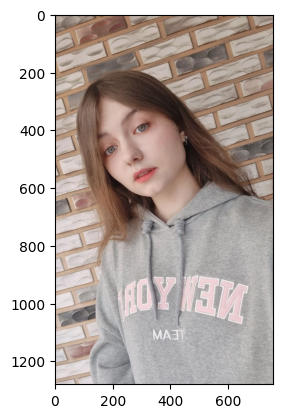

In [4]:
import matplotlib.pyplot as plt
my_image_path='/content/image.jpg'
img_bgr=cv2.imread(my_image_path)
img_rgb=cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.show()

In [5]:
detector_hog=dlib.get_frontal_face_detector()
dlib_rects=detector_hog(img_rgb,1)

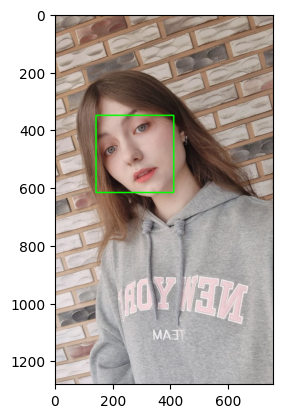

In [6]:
img_show=img_bgr.copy()
for dlib_rect in dlib_rects:
  l=dlib_rect.left()
  r=dlib_rect.right()
  t=dlib_rect.top()
  b=dlib_rect.bottom()

  cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 3)

img_show_rgb=cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2


--2025-07-28 02:44:44--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-07-28 02:44:44--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  36.4MB/s    in 1.7s    

2025-07-28 02:44:46 (36.4 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [8]:
!bzip2 -d '/content/shape_predictor_68_face_landmarks.dat.bz2'


In [9]:
landmark_predictor=dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

In [10]:
list_landmarks=[]
for dlib_rect in dlib_rects:
  points=landmark_predictor(img_rgb,dlib_rect)
  list_points=list(map(lambda p: (p.x,p.y), points.parts()))
  list_landmarks.append(list_points)

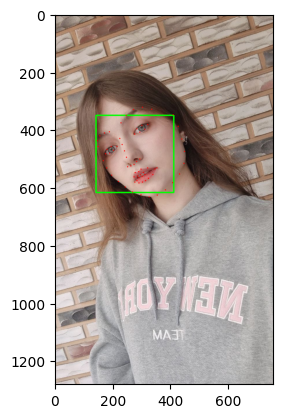

In [12]:
for landmark in list_landmarks:
    for point in landmark:
      cv2.circle(img_show, point, 2, (0,0,255), -1)
img_show_rgb=cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [13]:
sticker_path = '/content/cat-whiskers.png'
sticker = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)

In [16]:
nose_x, nose_y = list_landmarks[0][30]

w=dlib_rects[0].width()
h=int(sticker.shape[0] *(w/sticker.shape[1]))
img_sticker=cv2.resize(sticker, (w,h))

refined_x=nose_x-w//2
refined_y=nose_y-h//2

img_h, img_w=img_show.shape[:2]
if refined_x<0:
  img_sticker=img_sticker[:,-refined_x:]
  refined_x=0

if refined_y<0:
  img_sticker=img_sticker[-refined_y:,:]
  refined_y=0

if refined_x+img_sticker.shape[1]>img_w:
  img_sticker=img_sticker[:,:img_w-refined_x]

if refined_y+img_sticker.shape[0]>img_h:
  img_sticker=img_sticker[:img_h-refined_y,:]



In [17]:
overlay_area=img_show[refined_y:refined_y+img_sticker.shape[0],
                      refined_x:refined_x+img_sticker.shape[1]]

In [19]:
alpha_sticker=img_sticker[:,:,3]/255.0
alpha_face=1.0-alpha_sticker

for c in range(3):
  overlay_area[:,:,c]=(alpha_sticker*img_sticker[:,:,c]+
                        alpha_face*overlay_area[:,:,c])

img_show[refined_y:refined_y+img_sticker.shape[0],
         refined_x:refined_x+img_sticker.shape[1]]=overlay_area

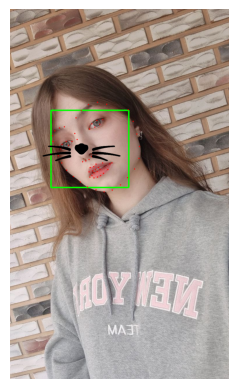

In [20]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 얼굴각도

In [33]:
import numpy as np
left_eye = list_landmarks[0][36]
right_eye = list_landmarks[0][45]
dx = right_eye[0] - left_eye[0]
dy = right_eye[1] - left_eye[1]
angle = np.degrees(np.arctan2(dy, dx))
print(f" {angle:.2f}°")

 -34.86°


In [34]:
center = (img_sticker.shape[1] // 2, img_sticker.shape[0] // 2)
M = cv2.getRotationMatrix2D(center, -angle, 1.0)
img_sticker = cv2.warpAffine(
        img_sticker,
        M,
        (img_sticker.shape[1], img_sticker.shape[0]),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0, 0)  # прозрачный фон
    )

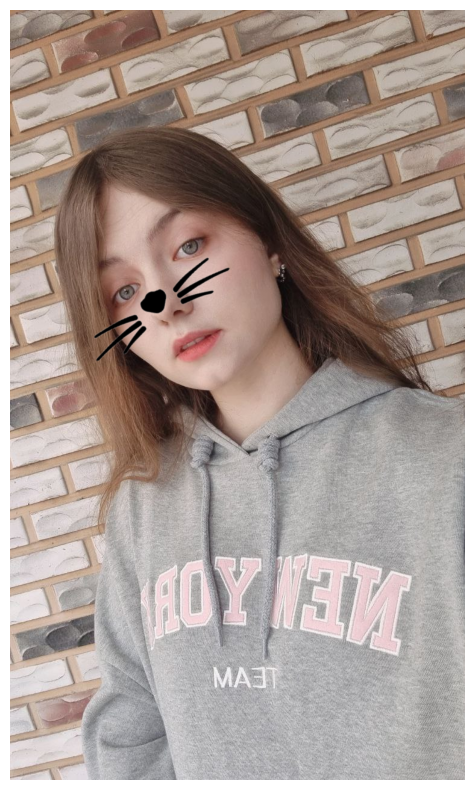

In [35]:
nose_x, nose_y = list_landmarks[0][30]
refined_x = nose_x - w // 2
refined_y = nose_y - h // 2

img_show = img_bgr.copy()
img_h, img_w = img_show.shape[:2]
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
if refined_x + img_sticker.shape[1] > img_w:
    img_sticker = img_sticker[:, :img_w - refined_x]
if refined_y + img_sticker.shape[0] > img_h:
    img_sticker = img_sticker[:img_h - refined_y, :]


overlay_area = img_show[refined_y:refined_y+img_sticker.shape[0],
                            refined_x:refined_x+img_sticker.shape[1]]

alpha_sticker = img_sticker[:, :, 3] / 255.0
alpha_face = 1.0 - alpha_sticker

for c in range(3):  # B, G, R
    overlay_area[:, :, c] = (alpha_sticker * img_sticker[:, :, c] +
                                 alpha_face * overlay_area[:, :, c])

img_show[refined_y:refined_y+img_sticker.shape[0],
             refined_x:refined_x+img_sticker.shape[1]] = overlay_area


plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# 밝기

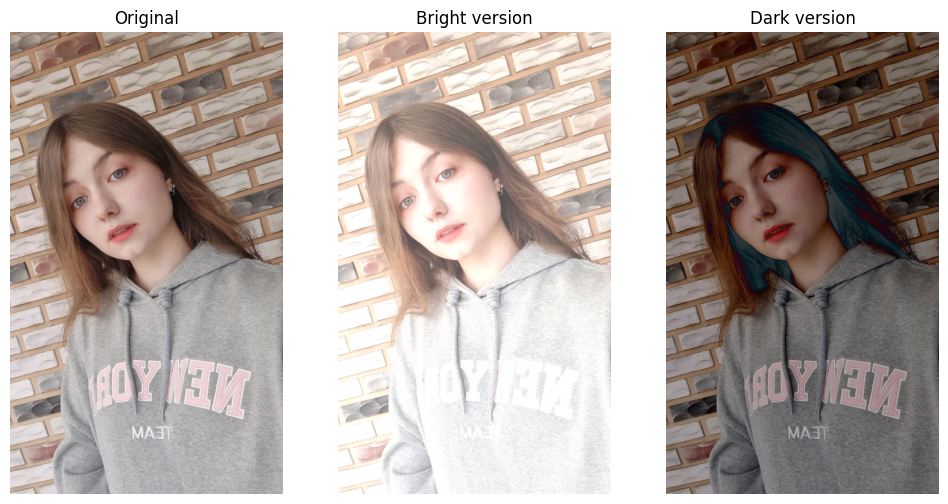

In [37]:
img_path = '/content/image.jpg'
img = cv2.imread(img_path)

bright_img=cv2.convertScaleAbs(img, alpha=1.0, beta=70)
dark_img=cv2.convertScaleAbs(img, alpha=1.0, beta=-70)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(bright_img, cv2.COLOR_BGR2RGB))
plt.title("Bright version")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(dark_img, cv2.COLOR_BGR2RGB))
plt.title("Dark version")
plt.axis('off')

plt.show()


In [38]:
dlib_rects1=detector_hog(bright_img,1)

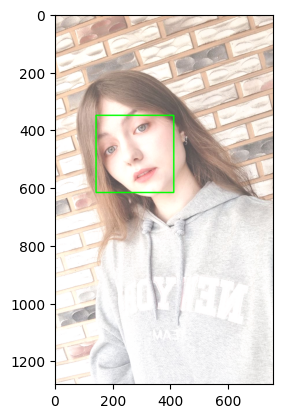

In [39]:
img_show=bright_img.copy()
for dlib_rect in dlib_rects1:
  l=dlib_rect.left()
  r=dlib_rect.right()
  t=dlib_rect.top()
  b=dlib_rect.bottom()

  cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 3)

img_show_rgb=cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

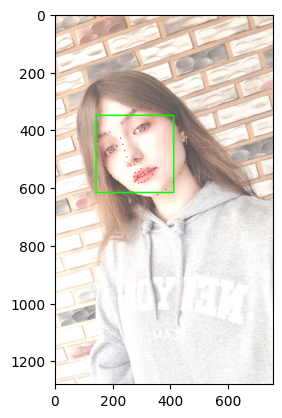

In [40]:
list_landmarks=[]
for dlib_rect in dlib_rects1:
  points=landmark_predictor(bright_img,dlib_rect)
  list_points=list(map(lambda p: (p.x,p.y), points.parts()))
  list_landmarks.append(list_points)
for landmark in list_landmarks:
    for point in landmark:
      cv2.circle(img_show, point, 2, (0,0,255), -1)
img_show_rgb=cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

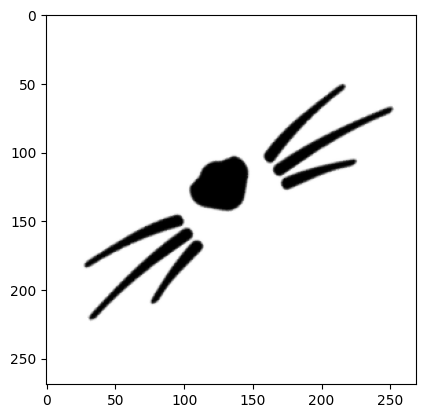

In [41]:
plt.imshow(img_sticker)

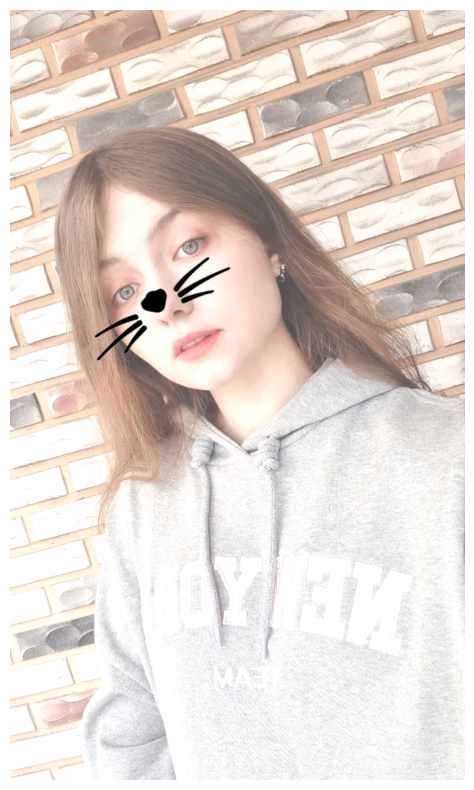

In [43]:
nose_x, nose_y = list_landmarks[0][30]
refined_x = nose_x - w // 2
refined_y = nose_y - h // 2

img_show = bright_img.copy()
img_h, img_w = img_show.shape[:2]
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
if refined_x + img_sticker.shape[1] > img_w:
    img_sticker = img_sticker[:, :img_w - refined_x]
if refined_y + img_sticker.shape[0] > img_h:
    img_sticker = img_sticker[:img_h - refined_y, :]


overlay_area = img_show[refined_y:refined_y+img_sticker.shape[0],
                            refined_x:refined_x+img_sticker.shape[1]]

alpha_sticker = img_sticker[:, :, 3] / 255.0
alpha_face = 1.0 - alpha_sticker

for c in range(3):  # B, G, R
    overlay_area[:, :, c] = (alpha_sticker * img_sticker[:, :, c] +
                                 alpha_face * overlay_area[:, :, c])

img_show[refined_y:refined_y+img_sticker.shape[0],
             refined_x:refined_x+img_sticker.shape[1]] = overlay_area


plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

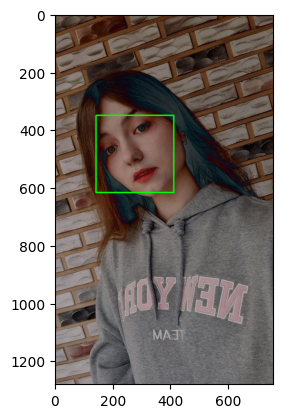

In [44]:
dlib_rects2=detector_hog(dark_img,1)
img_show=dark_img.copy()
for dlib_rect in dlib_rects2:
  l=dlib_rect.left()
  r=dlib_rect.right()
  t=dlib_rect.top()
  b=dlib_rect.bottom()

  cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 3)

img_show_rgb=cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

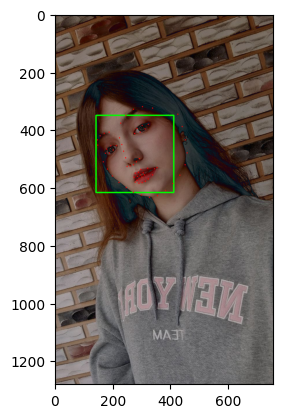

In [45]:
list_landmarks=[]
for dlib_rect in dlib_rects2:
  points=landmark_predictor(dark_img,dlib_rect)
  list_points=list(map(lambda p: (p.x,p.y), points.parts()))
  list_landmarks.append(list_points)
for landmark in list_landmarks:
    for point in landmark:
      cv2.circle(img_show, point, 2, (0,0,255), -1)
img_show_rgb=cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

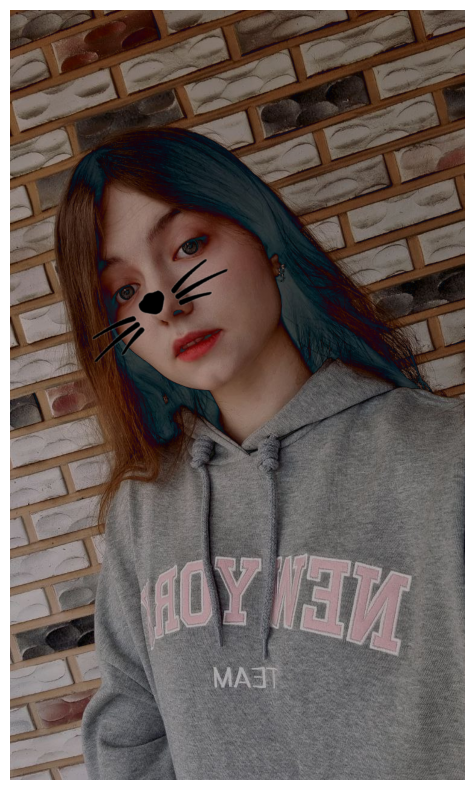

In [46]:
nose_x, nose_y = list_landmarks[0][30]
refined_x = nose_x - w // 2
refined_y = nose_y - h // 2

img_show = dark_img.copy()
img_h, img_w = img_show.shape[:2]
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
if refined_x + img_sticker.shape[1] > img_w:
    img_sticker = img_sticker[:, :img_w - refined_x]
if refined_y + img_sticker.shape[0] > img_h:
    img_sticker = img_sticker[:img_h - refined_y, :]


overlay_area = img_show[refined_y:refined_y+img_sticker.shape[0],
                            refined_x:refined_x+img_sticker.shape[1]]

alpha_sticker = img_sticker[:, :, 3] / 255.0
alpha_face = 1.0 - alpha_sticker

for c in range(3):  # B, G, R
    overlay_area[:, :, c] = (alpha_sticker * img_sticker[:, :, c] +
                                 alpha_face * overlay_area[:, :, c])

img_show[refined_y:refined_y+img_sticker.shape[0],
             refined_x:refined_x+img_sticker.shape[1]] = overlay_area


plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 촬영거리

In [67]:
zoom_factor = 1.5

zoomed = cv2.resize(img_bgr, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)

orig_h, orig_w = img_bgr.shape[:2]
new_h, new_w = zoomed.shape[:2]

start_x = (new_w - orig_w) // 2
start_y = (new_h - orig_h) // 2
end_x = start_x + orig_w
end_y = start_y + orig_h

zoomed_cropped = zoomed[start_y:end_y, start_x:end_x]

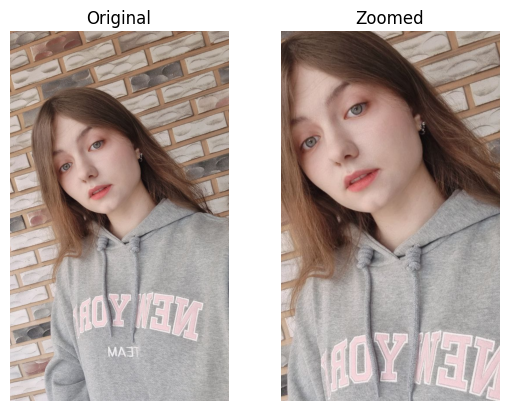

In [68]:
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(zoomed_cropped, cv2.COLOR_BGR2RGB))
plt.title('Zoomed')
plt.axis('off')

plt.show()

In [69]:
dlib_rects3=detector_hog(zoomed_cropped,1)

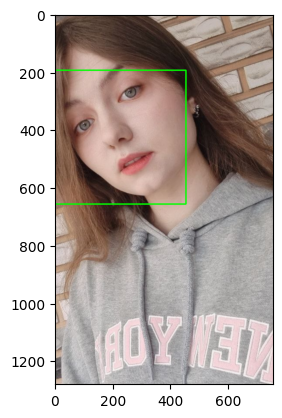

In [70]:
img_show=zoomed_cropped.copy()
for dlib_rect in dlib_rects3:
  l=dlib_rect.left()
  r=dlib_rect.right()
  t=dlib_rect.top()
  b=dlib_rect.bottom()

  cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 3)

img_show_rgb=cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

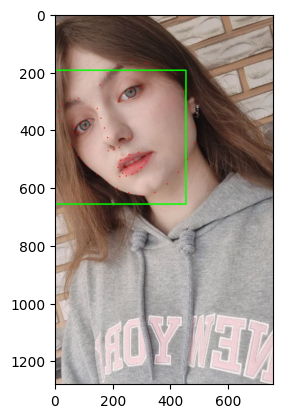

In [71]:
list_landmarks=[]
for dlib_rect in dlib_rects3:
  points=landmark_predictor(zoomed_cropped,dlib_rect)
  list_points=list(map(lambda p: (p.x,p.y), points.parts()))
  list_landmarks.append(list_points)
for landmark in list_landmarks:
    for point in landmark:
      cv2.circle(img_show, point, 2, (0,0,255), -1)
img_show_rgb=cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

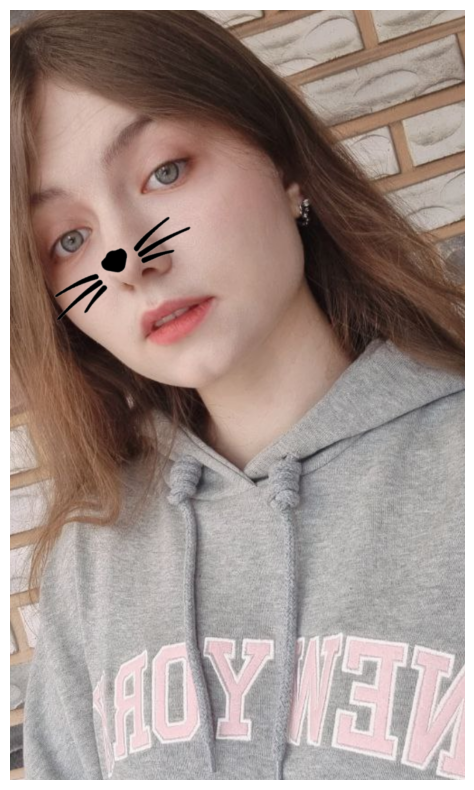

In [72]:
nose_x, nose_y = list_landmarks[0][30]
refined_x = nose_x - w // 2
refined_y = nose_y - h // 2

img_show = zoomed_cropped.copy()
img_h, img_w = img_show.shape[:2]
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
if refined_x + img_sticker.shape[1] > img_w:
    img_sticker = img_sticker[:, :img_w - refined_x]
if refined_y + img_sticker.shape[0] > img_h:
    img_sticker = img_sticker[:img_h - refined_y, :]


overlay_area = img_show[refined_y:refined_y+img_sticker.shape[0],
                            refined_x:refined_x+img_sticker.shape[1]]

alpha_sticker = img_sticker[:, :, 3] / 255.0
alpha_face = 1.0 - alpha_sticker

for c in range(3):  # B, G, R
    overlay_area[:, :, c] = (alpha_sticker * img_sticker[:, :, c] +
                                 alpha_face * overlay_area[:, :, c])

img_show[refined_y:refined_y+img_sticker.shape[0],
             refined_x:refined_x+img_sticker.shape[1]] = overlay_area


plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

**1. 실험 항목**

밝기 변화: 원본 / 매우 밝게 / 매우 어둡게

촬영 거리(줌): 원본 / 확대 (1.5x)

스티커 배치: 랜드마크(코) 기반 자동 위치

**2. 결과**

밝기: 매우 밝거나 어두운 경우에도 얼굴 및 랜드마크 인식이 정상적으로 작동 → 문제 없음

줌: 확대 시에도 얼굴 인식 및 랜드마크 정확도가 유지, 스티커 정상 적용 → 문제 없음

**얼굴 기울기**:

얼굴이 기울어진 경우 스티커가 적용되지만 각도를 고려하지 않아 부자연스러움

문제점: 알고리즘이 얼굴 각도를 반영하지 않고 스티커를 배치함

해결책: 눈 좌표(랜드마크 36, 45)를 이용해 각도를 계산하고 cv2.getRotationMatrix2D()로 스티커 회전 처리